# Decision tree

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st

In [2]:
model_name = "dtree"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline including:
- use randomised search to find optimal hyperparameters
- train best model on all training data

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_dist = {'max_depth': [None,2,4,6,8,10,12,14,16,18,20],
              'min_samples_split': st.randint(2, 50),
              'min_samples_leaf': st.randint(1, 100),
              'max_features': range(3,X.shape[1]+1)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=100,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.7s finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_s...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

Save model to AML shared directory

In [6]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
21,0.377671,0.002999,-10148.780517,-7063.856415,14,16,15,49,"{'min_samples_split': 49, 'min_samples_leaf': ...",1,-14650.066300,-9379.925458,-8225.559292,-6582.768602,-7570.715960,-5228.875184,0.180605,4.085107e-04,3194.097183,1728.465351
53,0.362170,0.007667,-10510.960908,-7152.495989,12,13,11,46,"{'min_samples_split': 46, 'min_samples_leaf': ...",2,-15802.183524,-9581.770513,-8188.678982,-6453.182818,-7542.020217,-5422.534636,0.150644,3.274708e-03,3750.761653,1768.537994
11,0.297170,0.011168,-10655.956082,-6981.482562,18,10,14,32,"{'min_samples_split': 32, 'min_samples_leaf': ...",3,-14526.970969,-8704.383691,-8879.212806,-6767.911538,-8561.684472,-5472.152457,0.137595,1.085190e-02,2740.288702,1328.166436
64,0.400171,0.004001,-10896.590576,-6445.174052,14,12,14,24,"{'min_samples_split': 24, 'min_samples_leaf': ...",4,-16991.487322,-9199.991343,-8047.756866,-5582.354074,-7650.527541,-4553.176737,0.178142,4.064668e-04,4312.792795,1992.747723
10,0.298005,0.004667,-11405.572073,-4295.913550,14,9,3,17,"{'min_samples_split': 17, 'min_samples_leaf': ...",5,-13541.517369,-4851.081925,-12128.146293,-4781.368073,-8547.052556,-3255.290652,0.136132,6.248176e-04,2102.023600,736.381703
56,0.403173,0.005331,-12070.306558,-9448.057208,10,15,26,41,"{'min_samples_split': 41, 'min_samples_leaf': ...",6,-17000.859620,-12346.912110,-9650.048740,-8384.476019,-9560.011314,-7612.783494,0.228361,2.056835e-03,3486.621269,2073.868711
2,0.220510,0.006506,-12466.923296,-5748.252101,16,8,5,23,"{'min_samples_split': 23, 'min_samples_leaf': ...",7,-17903.107897,-7656.895779,-10508.562029,-5359.181256,-8989.099963,-4228.679267,0.102296,3.544100e-03,3893.693063,1426.347130
63,0.385339,0.003500,-12476.158339,-10351.484194,14,14,36,19,"{'min_samples_split': 19, 'min_samples_leaf': ...",8,-17558.969629,-13701.094571,-10342.654946,-9478.303809,-9526.850443,-7875.054200,0.199230,4.066619e-04,3609.488625,2457.304701
42,0.358503,0.003669,-13014.548269,-10381.835556,None,13,36,46,"{'min_samples_split': 46, 'min_samples_leaf': ...",9,-18719.464201,-14008.214293,-9935.092612,-9146.947550,-10389.087995,-7990.344825,0.195265,4.730005e-04,4038.240318,2607.348529
26,0.408338,0.003668,-13198.113260,-10937.605817,14,17,43,6,"{'min_samples_split': 6, 'min_samples_leaf': 4...",10,-19331.889486,-14753.377107,-10821.364978,-10108.516278,-9441.085317,-7950.924067,0.243625,4.721026e-04,4373.686551,2838.295726


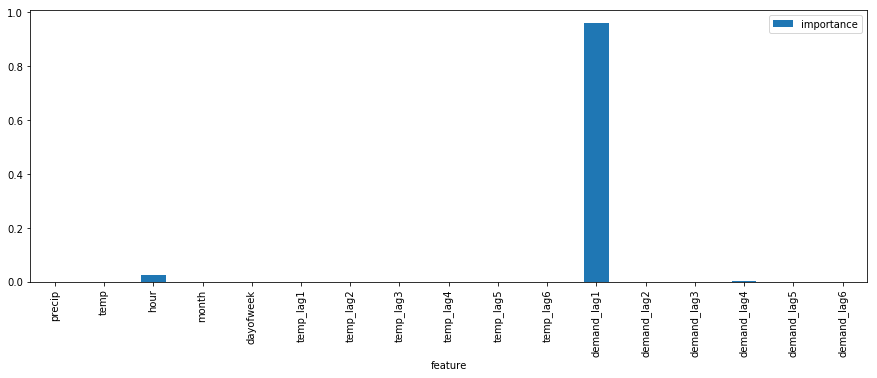

In [8]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5))
plt.show()